# EDA

In [45]:
# Importing Libraries

import os
from docx import Document
import pandas as pd
import re
import warnings
warnings.filterwarnings("ignore")

In [46]:
# Function to extract text from doc file

def extract_text_from_docx(file_path):
    try:
        doc = Document(file_path)
        return '\n'.join([para.text for para in doc.paragraphs])
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return ""

# Function to clean raw text (lowercasing, remove punctuation and extra spaces)
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Path to my main resume folder
root_folder = r"C:\Temp\Resumes_Docx"

# List to store data
resume_data = []

# Loop through each subfolder  ---------------------------------------------------------------------------------------------------
for folder in os.listdir(root_folder):
    folder_path = os.path.join(root_folder, folder)
    if os.path.isdir(folder_path):
        label = folder  # Use folder name as label
        for file in os.listdir(folder_path):
            if file.endswith('.docx'):
                file_path = os.path.join(folder_path, file)
                raw_text = extract_text_from_docx(file_path)
                resume_data.append({
                    'filename': file,
                    'label': label,
                    'text': raw_text,
                    'clean_text': clean_text(raw_text)
                })


In [47]:
# Create DataFrame
df = pd.DataFrame(resume_data)
df.head() 

#Visual inspect to DataFrame with filename, label, text, and cleaned text.
#Some files might be corrupted or not standard Word files. These are safely skipped in my code with exception handling

,filename,label,text,clean_text
0,Peoplesoft Admin_AnubhavSingh.docx,Peoplesoft Resume,Anubhav Kumar Singh\t\t\n\n To work in a gl...,anubhav kumar singh to work in a globally com...
1,Peoplesoft Admin_Murali.docx,Peoplesoft Resume,Murali\n\nExperience Summary \n\nI have 6 year...,murali experience summary i have 6 years of ex...
2,Peoplesoft Admin_SirazuddinMohammad.docx,Peoplesoft Resume,\n\n\n\n\n\n\n\n\n\n\n\n\n\nPROFILE SUMMARY\n\...,profile summary i have overall 68 years exper...
3,Peoplesoft Admin_Varkala Vikas.docx,Peoplesoft Resume,PeopleSoft Admin\nVARKALA VIKAS\n\nCareer Obj...,peoplesoft admin varkala vikas career objecti...
4,PeopleSoft DBA_Vivekanand Sayana.docx,Peoplesoft Resume,PeopleSoft Administration\n \nVivekanand Sayan...,peoplesoft administration vivekanand sayana ca...


In [48]:
#This function standardizes folder-based labels into clean class names. Ensures consistency across classes before modeling or EDA.

def normalize_label(label):
    label = label.lower().strip()
    if 'peoplesoft' in label:
        return 'Peoplesoft'
    elif 'react' in label:
        return 'React Developer'
    elif 'sql' in label:
        return 'SQL Developer'
    elif 'workday' in label:
        return 'Workday'
    else:
        return label.title()

df['label'] = df['label'].apply(normalize_label)
print(df['label'].value_counts())

label
React Developer    20
SQL Developer      11
Workday            11
Peoplesoft         10
Name: count, dtype: int64


In [49]:
#Explores structure, missing values, and basic stats. Useful to catch nulls or anomalies in the text and clean_text fields.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

print(df.info())          # dtypes, non‑null counts
print(df.describe())      # numeric stats (will show word_count later)
print(df.isna().mean())   # % of missing per column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    52 non-null     object
 1   label       52 non-null     object
 2   text        52 non-null     object
 3   clean_text  52 non-null     object
dtypes: object(4)
memory usage: 1.8+ KB
None
                                  filename            label  \
count                                   52               52   
unique                                  52                4   
top     Peoplesoft Admin_AnubhavSingh.docx  React Developer   
freq                                     1               20   

                                                     text  \
count                                                  52   
unique                                                 52   
top       Anubhav Kumar Singh\t\t\n\n  To work in a gl...   
freq                                                 

In [50]:
#Creates additional features to understand the resume length. These can be used in plots or as features in classification.
df['word_count'] = df['clean_text'].str.split().str.len()
df['char_count'] = df['clean_text'].str.len()

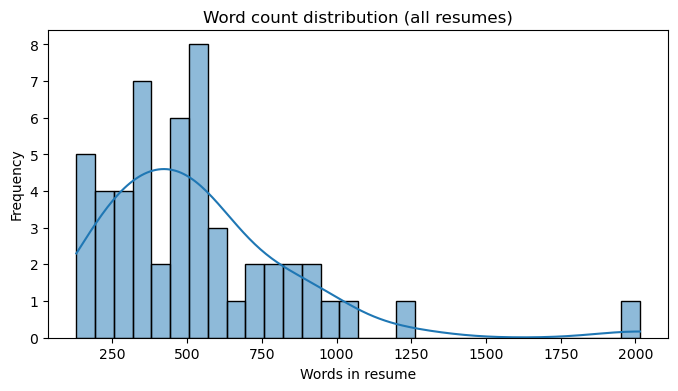

In [51]:
plt.figure(figsize=(8,4))
sns.histplot(df['word_count'], bins=30, kde=True)
plt.title('Word count distribution (all resumes)')
plt.xlabel('Words in resume')
plt.ylabel('Frequency')
plt.show()

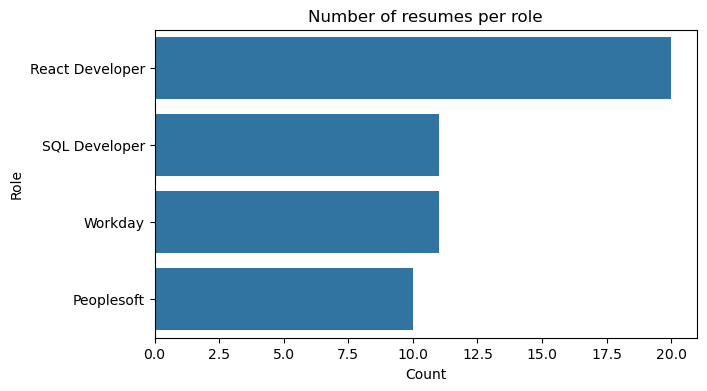

In [52]:
plt.figure(figsize=(7,4))
sns.countplot(data=df, y='label', order=df['label'].value_counts().index)
plt.title('Number of resumes per role')
plt.xlabel('Count')
plt.ylabel('Role')
plt.show()

# Model Building

In [53]:
#Importing Required libraries

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


In [54]:
X_text = df['clean_text']
y = df['label']

In [55]:
# Used the cleaned text for vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
bow = CountVectorizer(max_features=5000, stop_words='english')

In [56]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_models(X, y, vectorizer_name):
    print(f"\n📌 Using {type(vectorizer_name).__name__}:\n{'='*40}")
    
    # Text to vector
    X_vect = vectorizer_name.fit_transform(X)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42)

    # Define models
    models = {
        'Naive Bayes': MultinomialNB(),
        'SVM (Linear)': SVC(kernel='linear'),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(n_estimators=100)
    }

    trained_models = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        print(f"\n🧠 {name} Results:")
        print(f"Accuracy: {acc:.2f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred, zero_division=0))

        trained_models[name] = model

    return trained_models, vectorizer_name


In [57]:
evaluate_models(X_text, y, tfidf)
evaluate_models(X_text, y, bow)



📌 Using TfidfVectorizer:

🧠 Naive Bayes Results:
Accuracy: 0.91
Classification Report:
                 precision    recall  f1-score   support

     Peoplesoft       1.00      1.00      1.00         2
React Developer       0.80      1.00      0.89         4
  SQL Developer       0.00      0.00      0.00         1
        Workday       1.00      1.00      1.00         4

       accuracy                           0.91        11
      macro avg       0.70      0.75      0.72        11
   weighted avg       0.84      0.91      0.87        11


🧠 SVM (Linear) Results:
Accuracy: 0.91
Classification Report:
                 precision    recall  f1-score   support

     Peoplesoft       1.00      1.00      1.00         2
React Developer       0.80      1.00      0.89         4
  SQL Developer       0.00      0.00      0.00         1
        Workday       1.00      1.00      1.00         4

       accuracy                           0.91        11
      macro avg       0.70      0.75      0.72

({'Naive Bayes': MultinomialNB(),
  'SVM (Linear)': SVC(kernel='linear'),
  'Decision Tree': DecisionTreeClassifier(),
  'Random Forest': RandomForestClassifier()},
 CountVectorizer(max_features=5000, stop_words='english'))

In [58]:
trained_models_bow, bow_vectorizer = evaluate_models(X_text, y, bow)
nb_model_bow = trained_models_bow['Naive Bayes']



📌 Using CountVectorizer:

🧠 Naive Bayes Results:
Accuracy: 1.00
Classification Report:
                 precision    recall  f1-score   support

     Peoplesoft       1.00      1.00      1.00         2
React Developer       1.00      1.00      1.00         4
  SQL Developer       1.00      1.00      1.00         1
        Workday       1.00      1.00      1.00         4

       accuracy                           1.00        11
      macro avg       1.00      1.00      1.00        11
   weighted avg       1.00      1.00      1.00        11


🧠 SVM (Linear) Results:
Accuracy: 0.91
Classification Report:
                 precision    recall  f1-score   support

     Peoplesoft       1.00      1.00      1.00         2
React Developer       0.80      1.00      0.89         4
  SQL Developer       0.00      0.00      0.00         1
        Workday       1.00      1.00      1.00         4

       accuracy                           0.91        11
      macro avg       0.70      0.75      0.72

In [59]:
def predict_resume(file_path):
    raw_text = extract_text_from_docx(file_path)
    cleaned = clean_text(raw_text)
    vec = bow_vectorizer.transform([cleaned])  #  Use BoW vectorizer
    return nb_model_bow.predict(vec)[0]        #  Use BoW-trained model


In [60]:
result = predict_resume(r"C:\Temp\Resumes_Docx\React Developer\React Developer_Haripriya.docx")
print("Predicted Role:", result)


Predicted Role: React Developer


In [61]:
import joblib

# Save the Naive Bayes model trained with BoW
joblib.dump(nb_model_bow, 'nb_model_bow.pkl')

# Save the fitted BoW vectorizer
joblib.dump(bow_vectorizer, 'bow_vectorizer.pkl')


['bow_vectorizer.pkl']

In [63]:
# Run in cmd prompt

# cd C:\Temp\Deploy
# streamlit run app.py
